In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
import matplotlib.dates as mdates

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


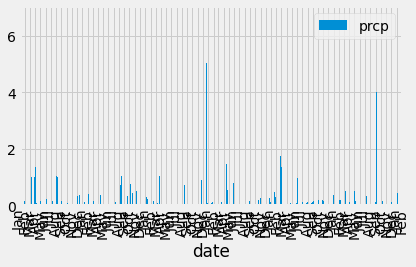

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
session.query(measurement.date, measurement.prcp, measurement.station).\
filter(measurement.date > query_date).\
order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql_query(session.query(measurement.date, measurement.prcp).\
filter(measurement.date > query_date).\
order_by(measurement.date).statement, session.bind)

# Sort the dataframe by date
df['prcp'] = df['prcp'].fillna(0)
df['date'] = pd.to_datetime(df.date)
df.sort_values(by='date')
df.set_index('date', inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data

ax=df.plot.bar()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(station.id)).all()

[(9,)]

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(measurement.station, func.count(measurement.id)).group_by(measurement.station).order_by(func.count(measurement.id)).all()

[('USC00518838', 511),
 ('USC00517948', 1372),
 ('USC00511918', 1979),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00519523', 2669),
 ('USC00513117', 2709),
 ('USC00519397', 2724),
 ('USC00519281', 2772)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
print(f"Max: {session.query(func.max(measurement.prcp)).filter(measurement.station =='USC00519281').all()}")
print(f"Min: {session.query(func.min(measurement.prcp)).filter(measurement.station =='USC00519281').all()}")
print(f"Avg: {session.query(func.avg(measurement.prcp)).filter(measurement.station =='USC00519281').all()}")

Max: [(9.64,)]
Min: [(0.0,)]
Avg: [(0.2123520923520915,)]


Text(0.5, 0, 'Temperature')

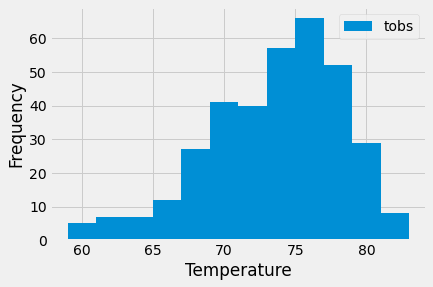

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df2 = pd.read_sql_query(session.query(measurement.date, measurement.tobs).\
filter(measurement.date > query_date, measurement.station == 'USC00519281').\
order_by(measurement.date).statement, session.bind)
ax = df2.plot.hist(by= df2['tobs'], bins=12)
ax.set_xlabel('Temperature')

# Close session

In [18]:
# Close Session
session.close()